# Photocurrent in $Al_x Ga_{1-x} As/GaAs$ Quantum Heterostructures

## Setup

In [1]:
import time
import numpy as np
import scipy.constants as cte
from scipy.signal import gaussian
from scipy.special import legendre
from scipy.sparse import diags
from scipy.linalg import inv
from scipy.integrate import simps
from scipy.optimize import newton
from scipy.interpolate import interp1d
from scipy.spatial.distance import cdist

### Charts Styles

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 75
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 14, 8
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "cm"

### Physical constants

In [6]:
au_l     = cte.value('atomic unit of length')
au_t     = cte.value('atomic unit of time')
au_e     = cte.value('atomic unit of energy')
ev       = cte.value('electron volt')
me       = cte.value('electron mass')
e        = cte.value('elementary charge')
c        = cte.value('speed of light in vacuum')
hbar     = cte.value('Planck constant over 2 pi')
hbar_evs = cte.value('Planck constant over 2 pi in eV s')
au2ang   = au_l / 1e-10
au2ev    = au_e / ev

### Parameters

In [42]:
L         = 500.0
B         = 50
N         = 1024 #2048
z_ang     = np.geomspace(-L/2, -L/4, B, endpoint=False)
z_ang     = np.append(z_ang, np.linspace(-L/4, L/4, N-2*B, endpoint=False))
z_ang     = np.append(z_ang, np.geomspace(L/4, L/2, B))
z_au      = z_ang / au2ang
z_ang_lin = np.linspace(-L/2, L/2, N)
z_au_lin  = z_ang_lin / au2ang

## Eigenvalues and Eigenfunctions

### Orthonormal Functions

In [8]:
def orthonormal(n=2, size=2048):
    """
    Return the first `n` orthonormal legendre polynoms weighted by a gaussian
    They are useful as kickstart arrays for a imaginary time evolution

    Params
    ------
    n : int
        The number of arrays
    size : int
        The number of points in each array
    """
    sg  = np.linspace(-1, 1, size) # short grid
    g   = gaussian(size, std=int(size/100)) # gaussian
    vls = [g*legendre(i)(sg) for i in range(n)]
    return np.array(vls, dtype=np.complex_)

### Flexible Index

In [9]:
def fi(v, i):
    """
    short for flex_index, find the index `i` in array `v`
    `i` might be float, so that for `i = 1.5`, the return would be
    `(v[2]+v[1])/2`
    
    Params
    ------
    v : array_like
        a list of real or complex numbers
    i : int
        a semi integer number between 0 and the vector's `v` length
    """
    if i < 0.0:
        return v[0]
    elif i >= len(v) - 1:
        return v[-1]
    
    try:
        i_up   = int(np.ceil(i))
        i_down = int(np.floor(i))
        return (v[i_up]+v[i_down])/2.0
    except:
        return 0.0

### Eigenvalues

In [10]:
def eigenvalue(z, V, psi, m):
    """
    calculate eigenvalue like E=<Psi|H|Psi>/<Psi|Psi>
    where H = T + `V`, T is the only kinect operator in one dimension
    
    Params
    ------
    z : array_like
        the coordinates grid
    V : array_like
        the potential
    psi : array_like
        the wave function
    m : array_like
        the (position dependent) effective mass
    """
    #dz    = z[1]-z[0]
    dz    = np.append(z[1:]-z[:-1], z[1]-z[0])
    dz2   = dz**2
    h_psi = np.zeros(N, dtype=np.complex_)
    
    for i in range(N):
        h_psi[i] = ((0.5/dz2[i])*(1.0/fi(m,i+0.5)+1.0/fi(m,i-0.5))+V[i])*psi[i]
        
        if i > 0:
            h_psi[i] += -(0.5/dz2[i])*(psi[i-1]/fi(m,i-0.5))
            
        if i < N-1:
            h_psi[i] += -(0.5/dz2[i])*(psi[i+1]/fi(m,i+0.5))
            
    psi_h_psi = simps(psi.conj()*h_psi, z)
    return (psi_h_psi / simps(psi.conj()*psi, z)).real

### Bound States

In [17]:
def bound_states(z, V, m, nmax=20, precision=1e-9):
    """
    find the bound eigenstates for a given potential `V` under the effective
    mass approximation (`m`)
    
    Params
    ------
    z : array_like
        the coordinates grid
    V : array_like
        the potential
    m : array_like
        the (position dependent) effective mass
    nmax : int
        since it uses the inverse interaction, it is the max number of
        kick start eigenvalues in a grid between `min(V)` and `max(V)`
    precision : float
        it is the max error allowed for each eigenvalue, the error is just
        (new_eigenalue_n - old_eigenalue_n)/old_eigenalue_n
    """
    
    forecast = np.linspace(np.min(V), np.max(V), nmax)
#     dz  = z[1]-z[0]
    dz    = np.append(z[1:]-z[:-1], z[1]-z[0])
    dz2 = dz**2
    
    # kick start eigenstates
    eigenstates = orthonormal(nmax, size=N)
#     ks = orthonormal(2*nmax, size=N)
#     eigenstates = np.array([ks[i]+ks[i+1] for i in range(0, 2*nmax, 2)])
    eigenvalues = np.zeros(nmax)
    
    # matrix diagonals
    sub_diag  = np.zeros(N-1, dtype=np.complex_)
    main_diag = np.zeros(N  , dtype=np.complex_)

    def get_invA(v_shift=0.0):
        """Applies a shift in the potential, same as H'=H-beta """
        for i in range(N):
            try:
                main_diag[i] = (0.5/dz2[i])*(1.0/fi(m,i+0.5)+1.0/fi(m,i-0.5)) \
                    +(V[i]-v_shift)
            except:
                main_diag[i] = 0.0

            if i < N-1:
                sub_diag[i] = -(0.5/dz2[i])*(1.0/fi(m,i+0.5))

        diagonals = [main_diag, sub_diag, sub_diag]
        A         = diags(diagonals, [0, -1, 1]).toarray()
        return inv(A)
            
    counters = np.zeros(nmax)
    timers = np.zeros(nmax)
    precisions = np.zeros(nmax)
    vectors_sqeuclidean = np.zeros(nmax)
    
    for s in range(nmax):
        last_ev = 1.0
        last_es = np.zeros(N, dtype=np.complex_)
        
        shift = forecast[s]
        invA = get_invA(shift)
        V_shifted = V-shift
        
        while True:
            start_time = time.time()
            eigenstates[s] = invA.dot(eigenstates[s])
            counters[s] += 1

#             # gram-shimdt
#             for j in range(s):
#                 proj = simps(eigenstates[s]*eigenstates[j].conj(), z)
#                 eigenstates[s] -= proj * eigenstates[j]

            # normalize
            A = np.sqrt(simps(eigenstates[s]*eigenstates[s].conj(), z))
            eigenstates[s] /= A
            timers[s] += time.time() - start_time

            eigenvalues[s] = eigenvalue(z,V_shifted,eigenstates[s],m)+shift

            # check precision
            precisions[s] = np.abs(1-eigenvalues[s]/last_ev)
            last_ev = eigenvalues[s]

            if precisions[s] < precision:
                XA = [np.abs(eigenstates[s])**2]
                XB = [np.abs(last_es)**2]
                vectors_sqeuclidean[s] = cdist(XA, XB, 'sqeuclidean')[0][0]
                break

            last_es = np.copy(eigenstates[s])
        print("[%d/%d] ready!" % (s+1, nmax))
    
    def get_break(a, x, n=10):
        """ finds where de deriative of the array a changes more than 5% """
        der_a = np.array(a[2:]-a[:-2])/np.array(x[2:]-x[:-2])
        for i in range(n, len(der_a)):
            last_n  = np.average(der_a[i-n:i-1])
            if last_n == 0 and der_a[i] != 0 \
                or last_n != 0 and np.abs(der_a[i]/last_n-1) > 0.05:
                return i
        return int(len(a)/3)
    
    sort_index  = eigenvalues.argsort()
    eigenvalues = eigenvalues[sort_index]
    eigenstates = eigenstates[sort_index]
    
    iz_left     = get_break(V, z)
    iz_right    = len(V)-get_break(V[::-1], z)
    golden_ones = [0]
    
    for i, value in enumerate(eigenvalues):
        # drop repeated and unbounded states
        if i == 0 or np.abs(eigenvalues[i]/eigenvalues[i-1]-1) < 0.1 \
            or eigenvalues[i] > np.max(V):
            continue
        
        # drop not confined states
        state     = eigenstates[i].copy()
        state_l   = state[:iz_left]
        state_m   = state[iz_left:iz_right]
        state_r   = state[iz_right:]
        int_left  = simps(state_l*state_l.conj(), z[:iz_left]).real
        int_mid   = simps(state_m*state_m.conj(), z[iz_left:iz_right]).real
        int_right = simps(state_r*state_r.conj(), z[iz_right:]).real
        
        if int_left+int_right > int_mid:
            continue
        
        golden_ones.append(i)
        
    return {
        'eigenvalues': eigenvalues[golden_ones],
        'eigenstates': eigenstates[golden_ones],
        'counters': counters[golden_ones],
        'timers': timers[golden_ones],
        'precisions': precisions[golden_ones],
        'squared_euclidean_dist': vectors_sqeuclidean[golden_ones]
    }

#     return {
#         'eigenvalues': eigenvalues,
#         'eigenstates': eigenstates,
#         'counters': counters,
#         'timers': timers,
#         'precisions': precisions,
#         'squared_euclidean_dist': vectors_sqeuclidean
#     }

### Double Barrier Quantum Well

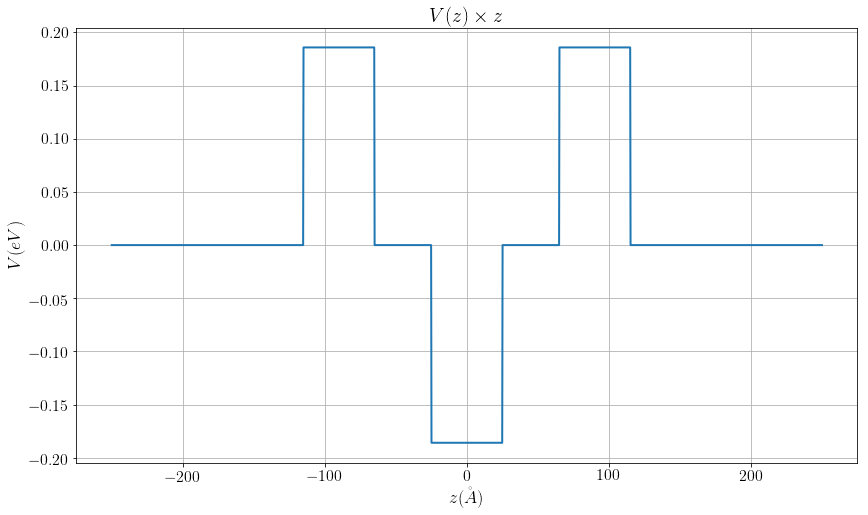

In [12]:
#g_algaas = lambda x: 1.519+1.447*x-0.15*x**2 # GAP
# Degani's actual potential
g_algaas = lambda x: 0.0 if x == 0.2 else (0.185897 if x == 0.4 else -0.185897)
m_algaas = lambda x: 0.067 + 0.083 * x # effective mass

xd       = 0.2 # displacement
xb       = 0.4 # barrier
xw       = 0.0 # well
wl       = 50.0 # Angstrom
bl       = 50.0 # Angstrom
dl       = 40.0 # Angstrom
CBO      = 0.655
VBO      = 0.345

def x_shape(z):
    if np.abs(z) < wl/2:
        return xw
    elif np.abs(z) < wl/2+dl:
        return xd
    elif np.abs(z) < wl/2+dl+bl:
        return xb
    return xd

V        = np.vectorize(lambda z: g_algaas(x_shape(z)))(z_ang)#*CBO
V       -= g_algaas(xd)#*CBO
#meff     = np.vectorize(lambda z: m_algaas(x_shape(z)))(z_ang)
# Degani's actual effective mass
meff     = np.vectorize(lambda z: m_algaas(xw))(z_ang)

fig, ax = plt.subplots()
ax.set_xlabel(r'$z (\AA)$')
ax.set_ylabel(r'$V (eV)$')
ax.plot(z_ang, V)
ax.set_title(r"$V(z) \times z$")
ax.grid(True)
plt.show()

### Potential and Coordinates grid in atomic units

In [13]:
V_au = V / au2ev
z_au = z_ang / au2ang

### Eigenvalues

In [16]:
res = bound_states(z_au, V_au, meff)
for i, value in enumerate(res['eigenvalues']):
    value  = value * au2ev # in eV
    print(r"E_%02d = %.8f eV" % (i, value))

[0/20] ready!
[1/20] ready!
[2/20] ready!
[3/20] ready!
[4/20] ready!
[5/20] ready!
[6/20] ready!
[7/20] ready!
[8/20] ready!
[9/20] ready!
[10/20] ready!
[11/20] ready!
[12/20] ready!
[13/20] ready!
[14/20] ready!
[15/20] ready!
[16/20] ready!
[17/20] ready!
[18/20] ready!
[19/20] ready!
E_00 = -0.11260124 eV
E_01 = 0.04043811 eV
E_02 = 0.13418340 eV


### Eigenstates

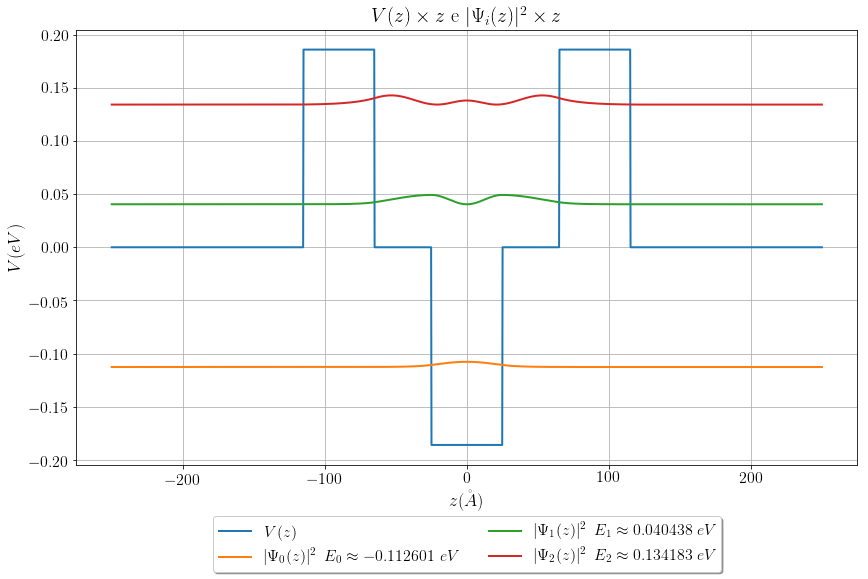

In [18]:
fig, ax = plt.subplots()
ax.set_xlabel(r'$z (\AA)$')
ax.set_ylabel(r'$V (eV)$')
ax.plot(z_ang, V, label=r'$V(z)$')

states = res['eigenstates'].copy()
for i, state in enumerate(states):
    state *= np.ptp(V) / np.ptp(np.abs(state)**2)/50.0
    _eivenvalue = res['eigenvalues'][i]* au2ev
    psi = (np.abs(state)**2).real + _eivenvalue
    ax.plot(z_ang, psi, label=r'$|\Psi_%d(z)|^2 \,\,\, E_%d \approx %.6f \,\, eV$' % (i, i, _eivenvalue))

ax.set_title(r"$V(z) \times z$ e $|\Psi_i(z)|^2 \times z$")
ax.grid(True)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),  shadow=True, ncol=2)
#plt.show()
plt.savefig('double_barrier_quantum_well_degani.png', bbox_inches='tight')

## Bias Potential

### Core Bias

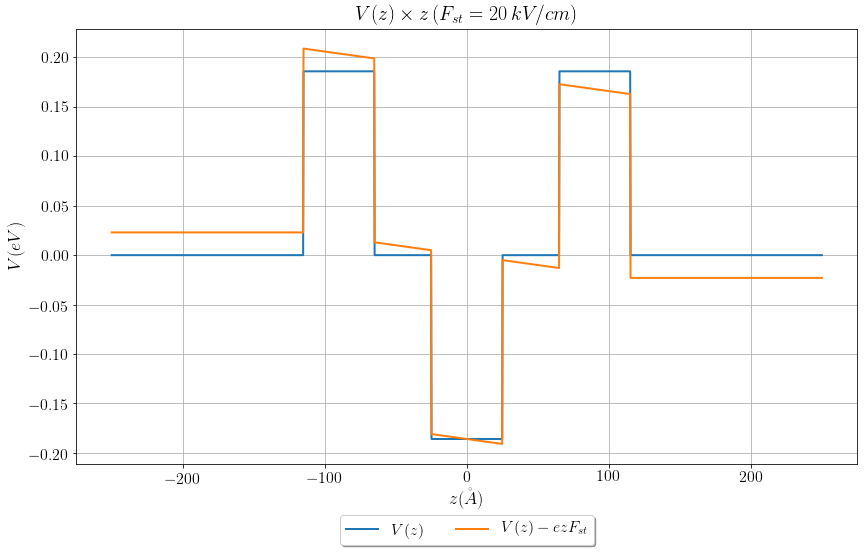

In [19]:
Fst           = (20e3)*(1e2) # kV/cm
Vst           = lambda z: -(z*1e-10)*(e*Fst)/ev
device_border = (wl/2.0+dl+bl)
V_left        = Vst(-device_border)
V_right       = Vst(device_border)

def find_bias(z):
    if z <= -device_border:
        return V_left
    elif z >= device_border:
        return V_right
    return Vst(z)

V_bias        = V+np.vectorize(find_bias)(z_ang)
V_bias_au     = V_bias / au2ev

fig, ax = plt.subplots()
ax.set_xlabel(r'$z (\AA)$')
ax.set_ylabel(r'$V (eV)$')
ax.plot(z_ang, V, label=r'$V(z)$')
ax.plot(z_ang, V_bias, label=r'$V(z) -e z F_{st}$')
ax.set_title(r"$V(z) \times z\, (F_{st}=20 \, kV/cm)$")
ax.grid(True)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),  shadow=True, ncol=2)
plt.show()

### Electrict Field of Interest

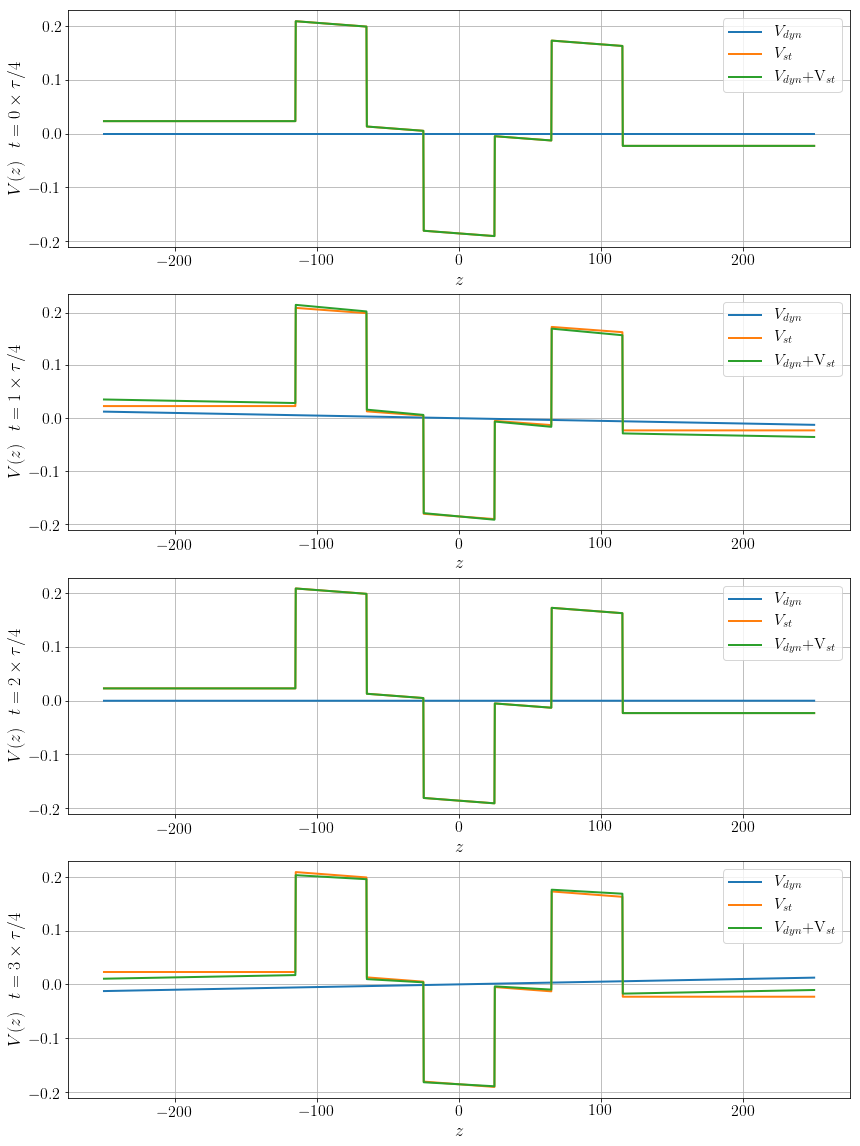

In [20]:
wave_length = 8.1e-6 # meters
frequency   = c / wave_length
omega       = 2.0 * np.pi * frequency
t_grid      = np.linspace(0.0, 1.0/frequency, N)
Fdyn        = (5e3)*(1e2) # kV/cm
Vdyn        = lambda z,t: -(z*1e-10)*(e*Fdyn*np.sin(omega*t))/ev

fig, axs = plt.subplots(4,1,figsize=(14,20))

for i, ax in enumerate(list(axs)):
    t         = t_grid[int(i*len(t_grid)/4)]
    V_dyn     = np.vectorize(Vdyn)(z_ang, np.ones(N)*t)
    
    ax.set_xlabel(r'$z$')
    ax.set_ylabel(r'$V(z)\,\,\,\,t= %d \times \tau/4 $'%i)
    
    ax.plot(z_ang, V_dyn, label=r'$V_{dyn}$')
    ax.plot(z_ang, V_bias, label=r'$V_{st}$')
    ax.plot(z_ang, V_bias+V_dyn, label=r'$V_{dyn}+$V_{st}$')
    ax.grid(True)
    ax.legend()

plt.show()

### Energy $\times$ Wavelength

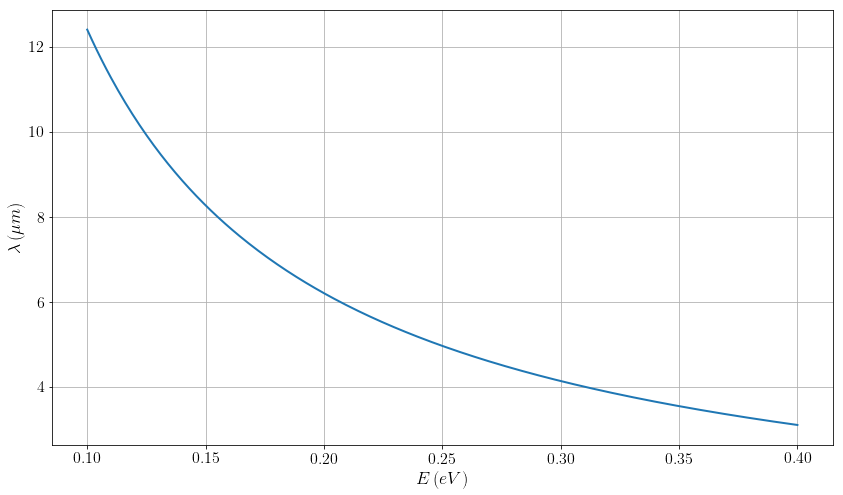

In [21]:
energies_ev = np.linspace(0.1, 0.4, 300)
energies_j  = energies_ev * ev
wlengths_um = (c/((energies_ev/hbar_evs)/(2*np.pi)))/1e-6

fig, ax = plt.subplots(1, 1, figsize=(14,8))
ax.set_xlabel(r'$E \, (eV)$')
ax.set_ylabel(r'$\lambda \, (\mu m)$')
ax.plot(energies_ev, wlengths_um)
ax.grid(True)
ax.legend()
plt.show()

### Absorbing Potential

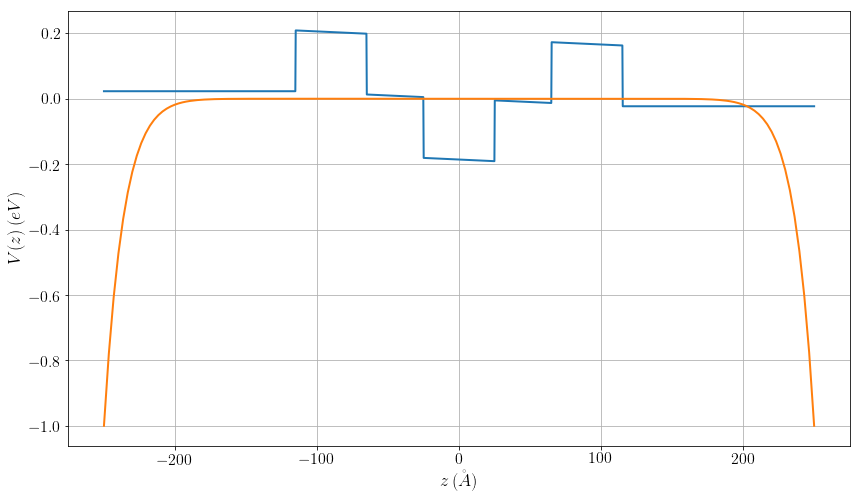

In [22]:
V_abs    = np.exp((z_ang/L)**18)-1.0
V_abs   *= -1/np.max(V_abs)
V_abs    = 1j*np.array(V_abs, dtype=np.complex_)
V_abs_au = V_abs / au2ev

fig, ax = plt.subplots(1, 1, figsize=(14,8))
ax.set_xlabel(r'$z \, (\AA)$')
ax.set_ylabel(r'$V(z) \, (eV)$')
ax.plot(z_ang, V_bias)
ax.plot(z_ang, V_abs.imag)
ax.grid(True)
ax.legend()
plt.show()

### Time Evolution

In [58]:
def generate_diagonals(z, m):
    dz          = np.append(z[1:]-z[:-1], z[1]-z[0])
    dz2         = dz**2
    sub_diag    = np.zeros(N-1, dtype=np.complex_)
    main_diag   = np.zeros(N  , dtype=np.complex_)

    for i in range(N):
        try:
            main_diag[i] = (0.5/dz2[i])*(1.0/fi(m,i+0.5)+1.0/fi(m,i-0.5))
        except:
            main_diag[i] = 0.0
        if i < N-1:
            sub_diag[i]  = -(0.5/dz2[i])*(1.0/fi(m,i+0.5))

    return main_diag, sub_diag

st_main_diag, st_sub_diag = generate_diagonals(z_au, meff)
        
def time_evolve(psi, V, dt):
    diagonals   = [st_main_diag+V, st_sub_diag, st_sub_diag]
    D           = diags(diagonals, [0, -1, 1]).toarray()
    k1          = D.dot(psi)
    k2          = D.dot(psi + dt * k1 / 2j)
    k3          = D.dot(psi + dt * k2 / 2j)
    k4          = D.dot(psi + dt * k3 / 1j)
    return psi+dt*(k1 + 2 * k2 + 2 * k3 + k4)/6j

### Bias Potential Eigenvalues/Eigenstates

In [24]:
res = bound_states(z_au, V_bias_au, meff)

[1/20] ready!
[2/20] ready!
[3/20] ready!
[4/20] ready!
[5/20] ready!
[6/20] ready!
[7/20] ready!
[8/20] ready!
[9/20] ready!
[10/20] ready!
[11/20] ready!
[12/20] ready!
[13/20] ready!
[14/20] ready!
[15/20] ready!
[16/20] ready!
[17/20] ready!
[18/20] ready!
[19/20] ready!
[20/20] ready!


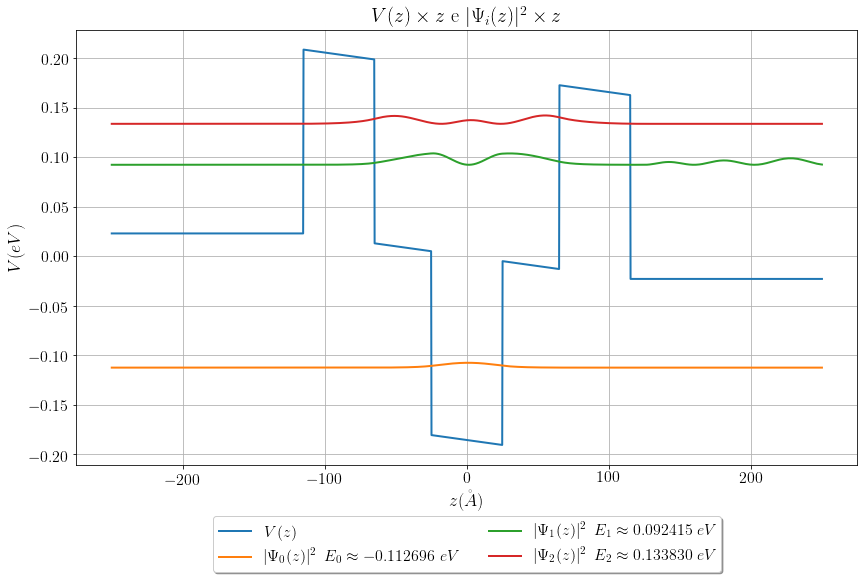

In [25]:
fig, ax = plt.subplots()
ax.set_xlabel(r'$z (\AA)$')
ax.set_ylabel(r'$V (eV)$')
ax.plot(z_ang, V_bias, label=r'$V(z)$')

states = res['eigenstates'].copy()
for i, state in enumerate(states):
    state *= np.ptp(V) / np.ptp(np.abs(state)**2)/50.0
    _eivenvalue = res['eigenvalues'][i]* au2ev
    psi = (np.abs(state)**2).real + _eivenvalue
    ax.plot(z_ang, psi, label=r'$|\Psi_%d(z)|^2 \,\,\, E_%d \approx %.6f \,\, eV$' % (i, i, _eivenvalue))

ax.set_title(r"$V(z) \times z$ e $|\Psi_i(z)|^2 \times z$")
ax.grid(True)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),  shadow=True, ncol=2)
plt.show()

### Time grid setup

In [73]:
psi    = res['eigenstates'][0].copy()
cycles = 20.0
T      = cycles / frequency
T_au   = T / au_t
dt     = T / 1e4
dt_au  = dt / au_t
t_grid = np.linspace(0.0, T, int(T / dt))
dt_au

2.23397964218028

### Photocurrent

In [ ]:
cl = int(N/4)
cr = int(3*N/4)
j  = []


def rk_f(t, y):
    V           = V_bias_au + (np.vectorize(Vdyn)(z_ang, np.ones(len(z_ang))*t))/au2ev + V_abs_au
    diagonals   = [st_main_diag+V, st_sub_diag, st_sub_diag]
    D           = diags(diagonals, [0, -1, 1]).toarray()
    return D.dot(y)/1j

r = ode(rk_f).set_integrator('zvode', method='bdf')
r.set_initial_value(psi, 0)

while r.successful() and r.t < T_au:
    r.integrate(r.t+dt_au)
    psi = r.y
    jl = ((-0.5j/(meff[cl])) * (psi[cl].conj() * (psi[cl+1]-psi[cl-1])-psi[cl]*(psi[cl+1].conj()-psi[cl-1].conj())) / (z_au[cl+1]-z_au[cl-1])).real
    jl = ((-0.5j/(meff[cr])) * (psi[cr].conj() * (psi[cr+1]-psi[cr-1])-psi[cr]*(psi[cr+1].conj()-psi[cr-1].conj())) / (z_au[cr+1]-z_au[cr-1])).real
    j.append(jr-jl)

I = (e/T) * simps(j, t_grid)    

# for i, t in enumerate(t_grid):
#     Vt     = V_bias_au + (np.vectorize(Vdyn)(z_ang, np.ones(len(z_ang))*t))/au2ev + V_abs_au
#     psi = time_evolve(psi, Vt, dt_au)
    
#     if i % 10000 == 0:
#         plt.plot(z_ang, np.abs(psi))
#         plt.show()
    
#     jl = ((-0.5j/(meff[cl])) * (psi[cl].conj() * (psi[cl+1]-psi[cl-1])-psi[cl]*(psi[cl+1].conj()-psi[cl-1].conj())) / (z_au[cl+1]-z_au[cl-1])).real
#     jl = ((-0.5j/(meff[cr])) * (psi[cr].conj() * (psi[cr+1]-psi[cr-1])-psi[cr]*(psi[cr+1].conj()-psi[cr-1].conj())) / (z_au[cr+1]-z_au[cr-1])).real
#     j.append(jr-jl)

#I = (e/T) * simps(j, t_grid)

In [61]:
from scipy.integrate import ode

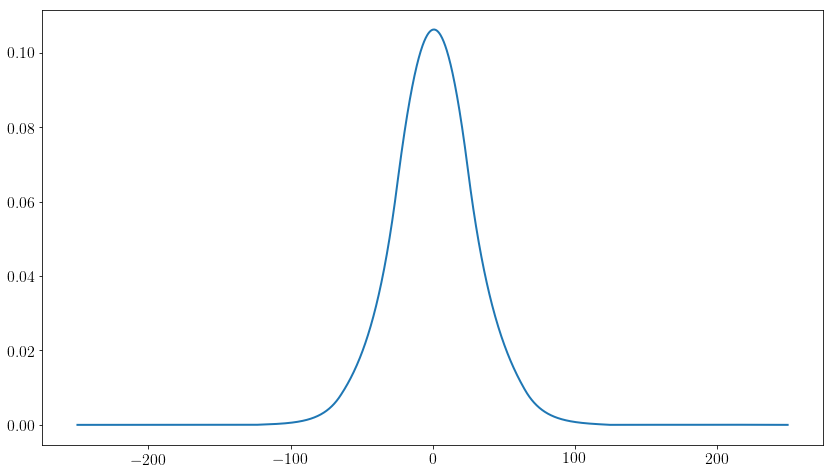

In [75]:
plt.plot(z_ang, np.abs(psi))
plt.show()

In [72]:
T_au

22339.7964218028